# Predicting stress using wearable sensors (Nurses)

---

**Project Information:**

- Project Name: Data Cleaning and Preprocessing Notebook
- Author: Syed Muhammad Shariq Ali
- Reg No: 2201831
- Date: 02-21-2023

## Importing the Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from datetime import datetime,timedelta
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from Functions import combine,re_sample,plot_confusion_matrix,calculate_statistics

In [2]:
raw_path = "F:/Masters/Data_Science/Data/" 
processed_path = "F:/Masters/Data_Science/Processed_Data/" 
survey_path = "F:/Masters/Data_Science/"

## Data Preprocessing and Merging
*   **Combining the Sensor Data present in different folders**
*   **Converting the Timestamp to Datetime**
*   **Merging the Sensor Data with the Survey Data**

In [3]:
# Data Combination
# Iterating over all the folders and combining the different signals in a single file

all_nurses = pd.DataFrame()
for nurse in os.listdir(raw_path):
    print("Started Folder = ",nurse)
    p2 = raw_path+nurse+'/'
    
    all_records = pd.DataFrame()
    for record in os.listdir(p2):
        p = p2+record+'/'
        
        for file in ["ACC","BVP","EDA","TEMP"]:
            if ["ACC","BVP","EDA","TEMP"].index(file) == 0:
                comb = combine(pd.read_csv(f"{p}{file}.csv",header=None),file)
            else:
                comb = comb.merge(combine(pd.read_csv(f"{p}{file}.csv",header=None),file),how="outer",on=["Datetime"])
            
        all_records = pd.concat([all_records,comb])
    
    all_records["Nurse"] = nurse
    all_nurses = pd.concat([all_nurses,all_records])

all_nurses = all_nurses.reset_index(drop=True)
all_nurses.to_feather(processed_path+"all_data.feather")

Started Folder =  15
Started Folder =  5C
Started Folder =  6B
Started Folder =  6D
Started Folder =  7A
Started Folder =  7E
Started Folder =  83
Started Folder =  8B
Started Folder =  94
Started Folder =  BG
Started Folder =  CE
Started Folder =  DF
Started Folder =  E4
Started Folder =  EG
Started Folder =  F5


In [4]:
# Data Merging
# Keeping only the Sensor Values that fall between the Start and End times given in the Survey file

data = pd.read_feather(processed_path+"all_data.feather")
data["Nurse"] = data["Nurse"].astype(str)
data["Date"] = data["Datetime"].dt.date
data["Date"] = pd.to_datetime(data["Date"],format="%Y-%m-%d")

# Converting Survey File Start and End times to GMT
survey_data = pd.read_excel(survey_path+"SurveyResults.xlsx")
survey_data = survey_data.rename(columns={"ID":"Nurse"})
survey_data["Nurse"] = survey_data["Nurse"].astype(str)
survey_data = survey_data.drop(["duration","Administration, lab, pharmacy, radiology, or other ancilliary services\n","Description"],axis=1)
survey_data = survey_data.replace({"na":np.nan}).dropna()
survey_data = survey_data.reset_index(drop=True)

survey_data['Start datetime'] =  pd.to_datetime(survey_data['date'].map(str) + ' ' + survey_data['Start time'].map(str))
survey_data['End datetime'] =  pd.to_datetime(survey_data['date'].map(str) + ' ' + survey_data['End time'].map(str))
survey_data.drop(['Start time','End time','date'], axis=1, inplace=True)

daylight = pd.to_datetime(datetime(2020,11,1,0,0))

survey_data1 = survey_data[survey_data['End datetime'] <= daylight].copy()
survey_data1['Start datetime'] = survey_data1['Start datetime'].apply(lambda x: x + timedelta(hours=5))
survey_data1['End datetime'] = survey_data1['End datetime'].apply(lambda x: x + timedelta(hours=5))
survey_data2 = survey_data.loc[survey_data['End datetime'] > daylight].copy()
survey_data2['Start datetime'] = survey_data2['Start datetime'].apply(lambda x: x + timedelta(hours=6))
survey_data2['End datetime'] = survey_data2['End datetime'].apply(lambda x: x + timedelta(hours=6))
survey_data = pd.concat([survey_data1, survey_data2])
survey_data = survey_data.reset_index(drop=True)

# Merging the two Data sets
comb_df = pd.DataFrame()
for k,v in survey_data.iterrows():
    temp = data.loc[((data.Nurse==str(survey_data.Nurse.iloc[k]))&
                     (data.Datetime>=survey_data["Start datetime"].iloc[k])&
                     (data.Datetime<=survey_data["End datetime"].iloc[k]))]
    temp = temp.reset_index(drop=True)
    temp["Nurse"] = temp["Nurse"].astype(str)
    if len(temp)>0:
        temp = temp.merge(survey_data.iloc[[k]],how="left",on=["Nurse"])
        comb_df = pd.concat([comb_df,temp])
    
comb_df.to_csv(processed_path+"Combined_Data.csv",index=False)

In [5]:
del all_nurses
del comb_df

## Data Visualization and Analysis
*   **Time-Series Plots**
*   **Stress Duration Chart**
*   **Box Plots**

In [6]:
# Renaming Columns in the Final Preprocessed dataset

data = pd.read_csv(processed_path+"Combined_Data.csv",low_memory=False)
data["Nurse"] = data["Nurse"].astype(str)
data = data.rename(columns={"TEMP":"Temperature","EDA":"Electrodermal Activity","BVP":"Blood Volume Pulse"})
data["ACC"] = np.sqrt(data["ACC_X"]**2 + data["ACC_Y"]**2 + data["ACC_Z"]**2)

In [7]:
# Converting Date and time values from String to Datetime format

data["Date"] = pd.to_datetime(data["Date"],format="%Y-%m-%d")
data["Datetime"] = pd.to_datetime(data["Datetime"],format="%Y-%m-%d %H:%M:%S")
data["Start datetime"] = pd.to_datetime(data["Start datetime"],format="%Y-%m-%d %H:%M:%S")
data["End datetime"] = pd.to_datetime(data["End datetime"],format="%Y-%m-%d %H:%M:%S")

In [8]:
print("The Shape of the Final Dataset is =",data.shape)
data.head()

The Shape of the Final Dataset is = (1160263, 25)


,Datetime,ACC_X,ACC_Y,ACC_Z,Blood Volume Pulse,Electrodermal Activity,Temperature,Nurse,Date,Stress level,...,Increased Workload,Technology related stress,Lack of supplies,Documentation,Competency related stress,Saftey (physical or physiological threats),Work Environment - Physical or others: work processes or procedures,Start datetime,End datetime,ACC
0,2020-04-14 22:31:00.000,-32.0,-38.875,127.0,-37.798750,5.332629,36.41,5C,2020-04-14,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-04-14 22:31:00,2020-04-14 22:58:00,136.617223
1,2020-04-14 22:31:00.250,-32.0,-38.625,127.0,40.518750,5.342877,36.41,5C,2020-04-14,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-04-14 22:31:00,2020-04-14 22:58:00,136.546295
2,2020-04-14 22:31:00.500,-32.0,-38.750,127.0,-9.113125,5.360812,36.41,5C,2020-04-14,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-04-14 22:31:00,2020-04-14 22:58:00,136.581706
3,2020-04-14 22:31:00.750,-32.0,-39.000,127.0,-4.811875,5.354406,36.41,5C,2020-04-14,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-04-14 22:31:00,2020-04-14 22:58:00,136.652845
4,2020-04-14 22:31:01.000,-32.0,-39.000,127.0,21.221875,5.346720,36.41,5C,2020-04-14,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-04-14 22:31:00,2020-04-14 22:58:00,136.652845


**Source: Tableau Visualization Software**

This Plot indicates the number of rows(shifts) that are available for each Nurse after aligning it with the Survey Results.

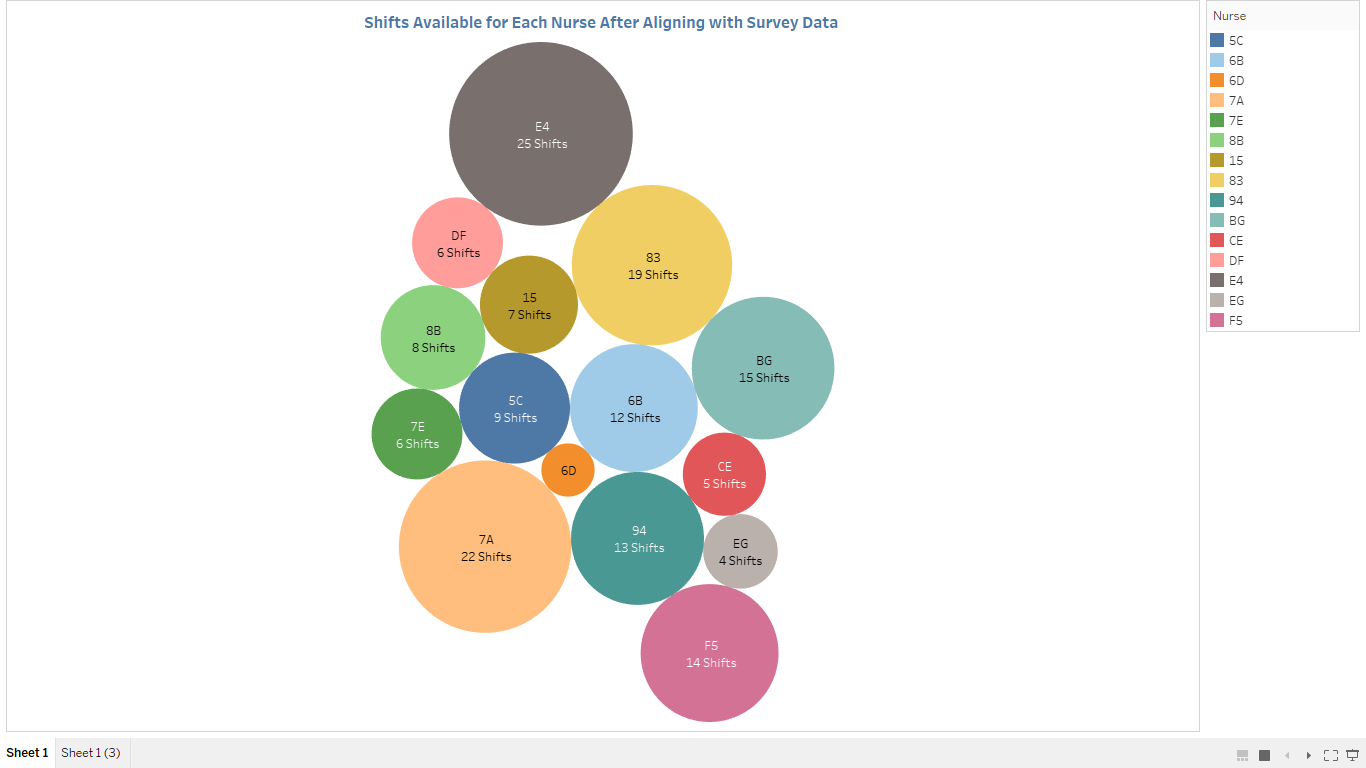

**Sensor TimeSeries Plot**

A Timeseries plot that illustrates the actual data received from one of the sensors. A scatter plot is used to display the data and the stress level for each data point as per the conducted survey is identified using color.

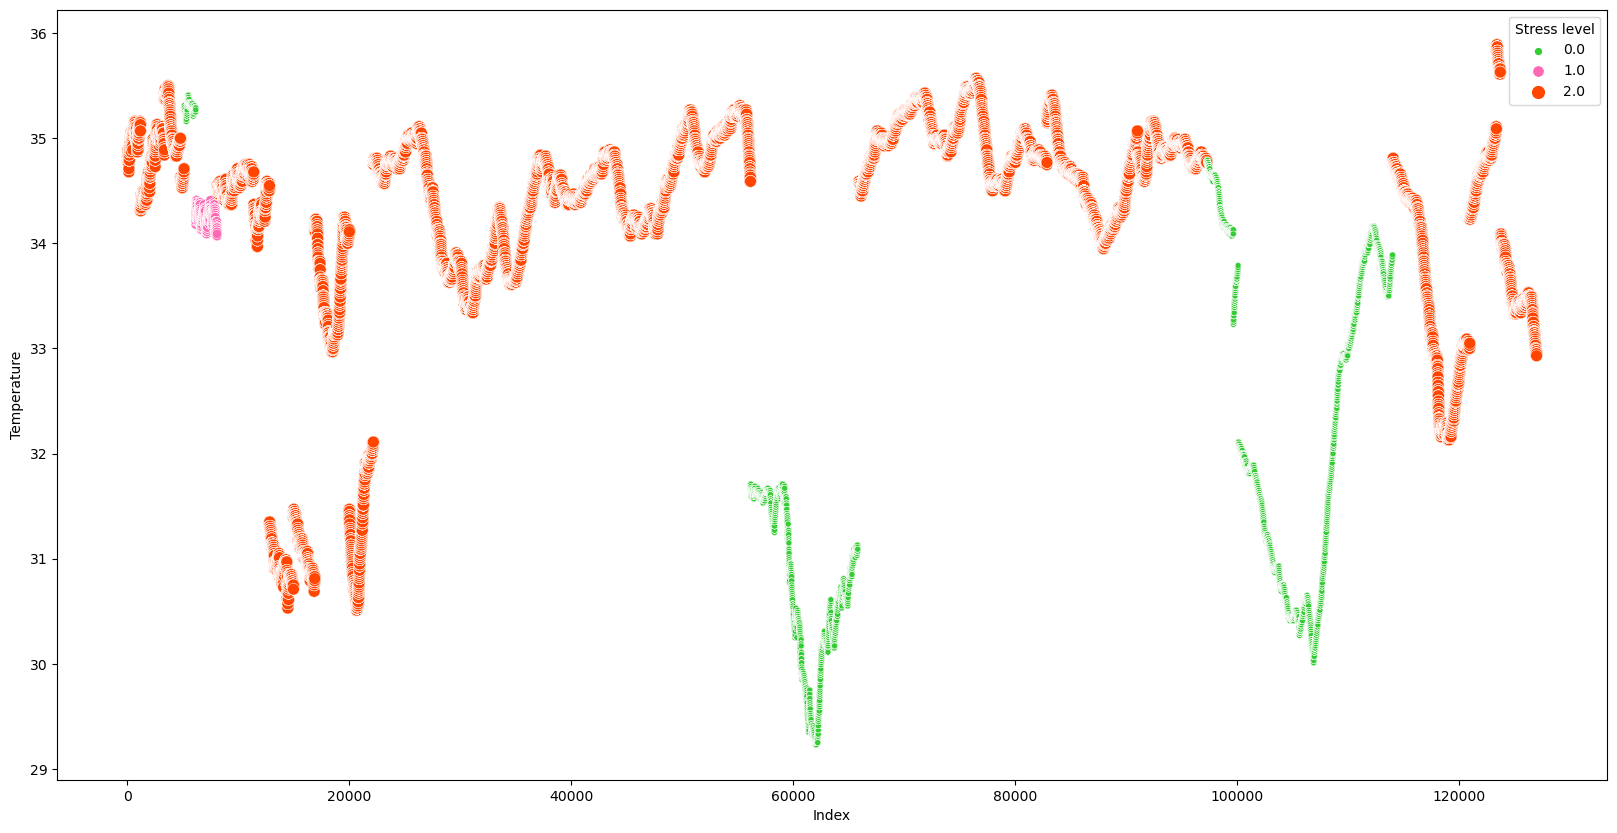

In [9]:
# Plotting the Sensor Timeseries of a Nurse using a Scatter plot
# It can be observed that when Stressed, the Temperature is higher overall

plt.figure(figsize=(20,10))
my_pal = {stress: "limegreen" if stress == 0 else "hotpink" if stress == 1 else "orangered" for stress in data["Stress level"].unique()}
sns.scatterplot(x=data.loc[data.Nurse=="E4","Temperature"].reset_index(drop=True).index,
                y=data.loc[data.Nurse=="E4","Temperature"].reset_index(drop=True),
                hue=data.loc[data.Nurse=="E4","Stress level"].reset_index(drop=True),
                size=data.loc[data.Nurse=="E4","Stress level"].reset_index(drop=True),
                palette=my_pal)

plt.xlabel("Index")
plt.show()

**Stress Duration Chart**

A Stacked Bar chart that illustrates the duration in minutes of the stress data available for different nurses. Each bar on the chart is composed of stacked sections that correspond to different levels of stress. The colors of the stacked sections are determined by the color argument specified in the code.

This Plot can be used to identify if the data of any one of the Nurses contains only a single stress level which may be a result of an incorrect/incomplete response during the survey and can be used for technical validation

In [10]:
# Stress Duration Chart
# Grouping the Data on Nurse and Stress Level and then calculating the time difference in minutes
# Summing that difference

stress_duration = data.groupby(by=["Nurse","Stress level"]).apply(lambda x:(x["End datetime"]-x["Start datetime"]).astype('timedelta64[m]'))
stress_duration = stress_duration.reset_index().drop("level_2",axis=1).rename(columns={0:"Duration(min)"})
stress_duration = stress_duration.groupby(by=["Nurse","Stress level"],as_index=False)["Duration(min)"].mean()
stress_duration = stress_duration.pivot_table(values="Duration(min)",columns="Stress level",index="Nurse",fill_value=0)
stress_duration = stress_duration.reset_index()
stress_duration.columns.name = None
stress_duration.columns = ["Nurse"]+["Stress_"+str(col) for col in list(stress_duration.columns) if col !="Nurse"]
stress_duration = stress_duration.loc[((stress_duration.Nurse!="15")&(stress_duration.Nurse!="6D")&(stress_duration.Nurse!="CE")&(stress_duration.Nurse!="DF")&(stress_duration.Nurse!="EG"))]

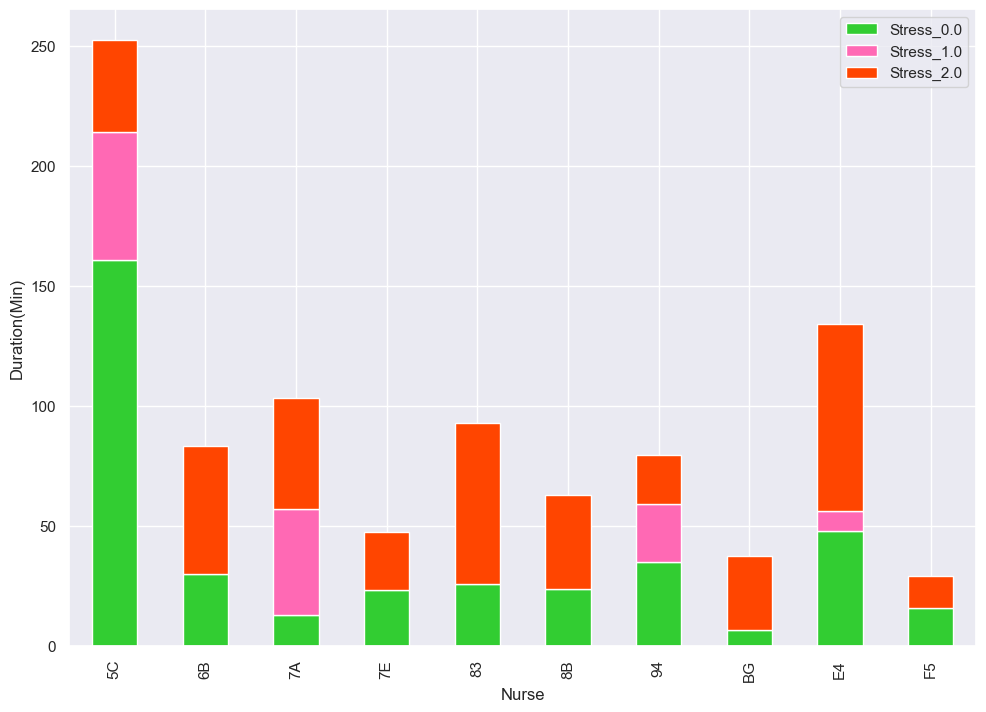

In [11]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
stress_duration.set_index('Nurse').plot(kind='bar',stacked=True,color=['limegreen','hotpink','orangered'])
plt.ylabel("Duration(Min)")
plt.show()

In [12]:
# Box Plot Dataframe
# Keeping the data of Nurses that have more than one unique stress level

box_plot_df = pd.DataFrame()
for nurse in list(data.Nurse.unique()):
    temp = data.loc[data.Nurse==nurse]
    if temp["Stress level"].nunique() > 1:
        temp = temp[["Nurse","Stress level","ACC","Temperature","Blood Volume Pulse","Electrodermal Activity"]]
        box_plot_df = pd.concat([box_plot_df,temp])
my_pal = {stress: "limegreen" if stress == 0 else "hotpink" if stress == 1 else "orangered" for stress in box_plot_df["Stress level"].unique()}

**Temperature Box Plot**

A Grouped Box Plot that compares the Temperature values for different nurses, with the boxes colored according to the stress level experienced by each nurse.

It can be observed that generally Nurses had a higher Median Temperature when they were stressed.

<AxesSubplot:xlabel='Nurse', ylabel='Temperature'>

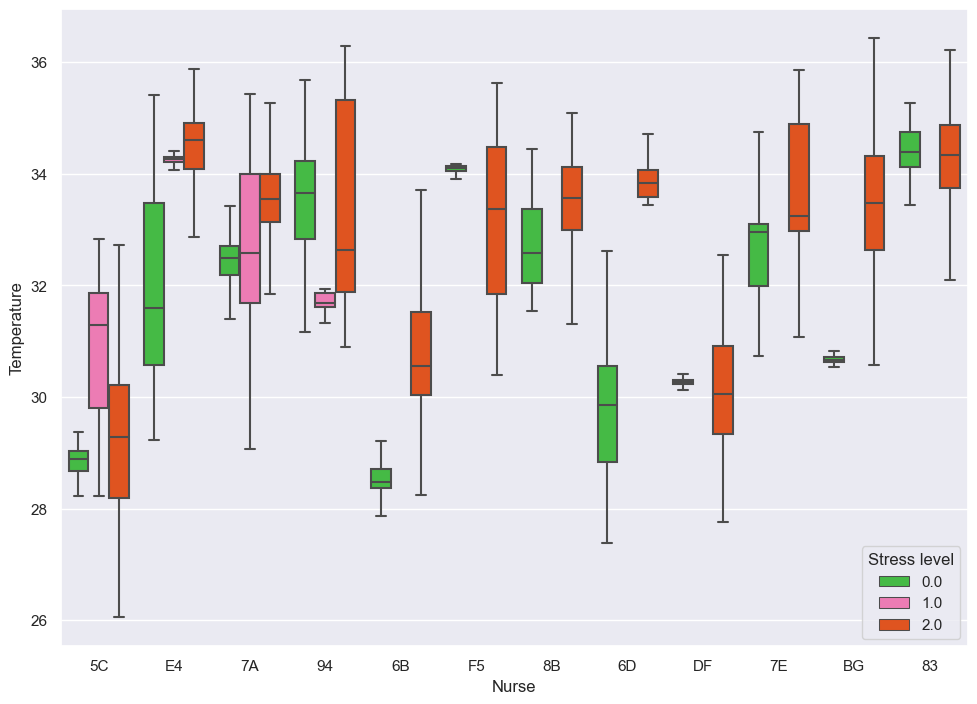

In [13]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='Nurse',y='Temperature',hue='Stress level',data=box_plot_df,palette=my_pal,showfliers = False)

**Blood Volume Pulse (BVP)**

A Grouped Box Plot that compares the Blood Volume Pulse values for different nurses, with the boxes colored according to the stress level experienced by each nurse.

There is no apparent difference in the BVP of Nurses during different stress levels

<AxesSubplot:xlabel='Nurse', ylabel='Blood Volume Pulse'>

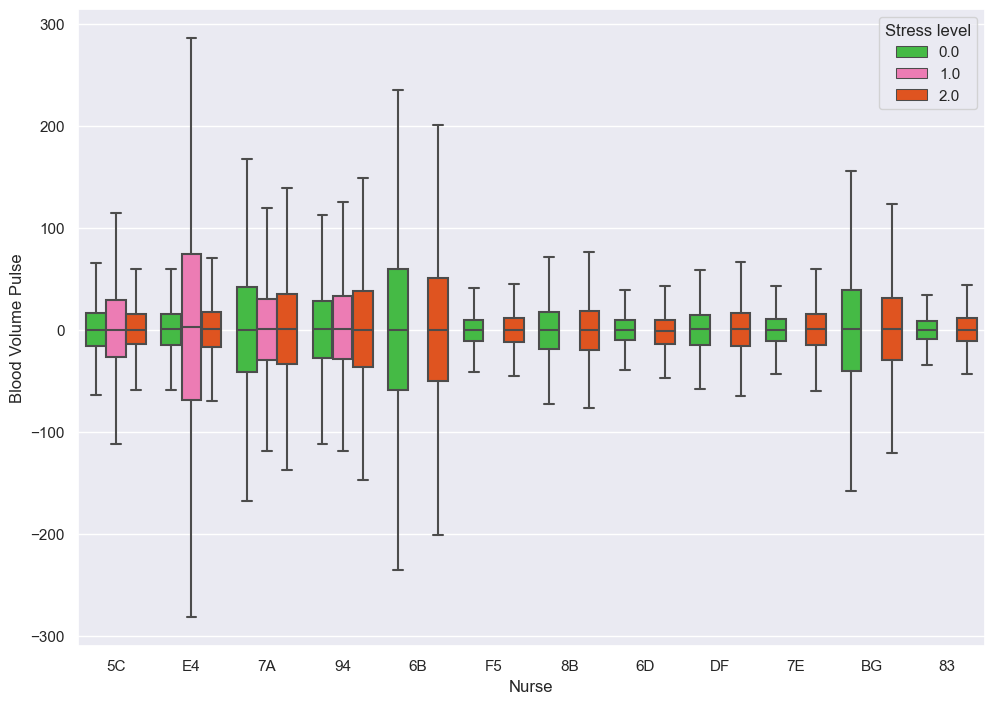

In [14]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='Nurse',y='Blood Volume Pulse',hue='Stress level',data=box_plot_df,palette=my_pal,showfliers = False)

**Electrodermal Activity**

A Grouped Box Plot that compares the Electrodermal Activity values for different nurses, with the boxes colored according to the stress level experienced by each nurse.

It can be observed that there is huge variance of the Electrodermal values in stressful situation as compared to normal situations

<AxesSubplot:xlabel='Nurse', ylabel='Electrodermal Activity'>

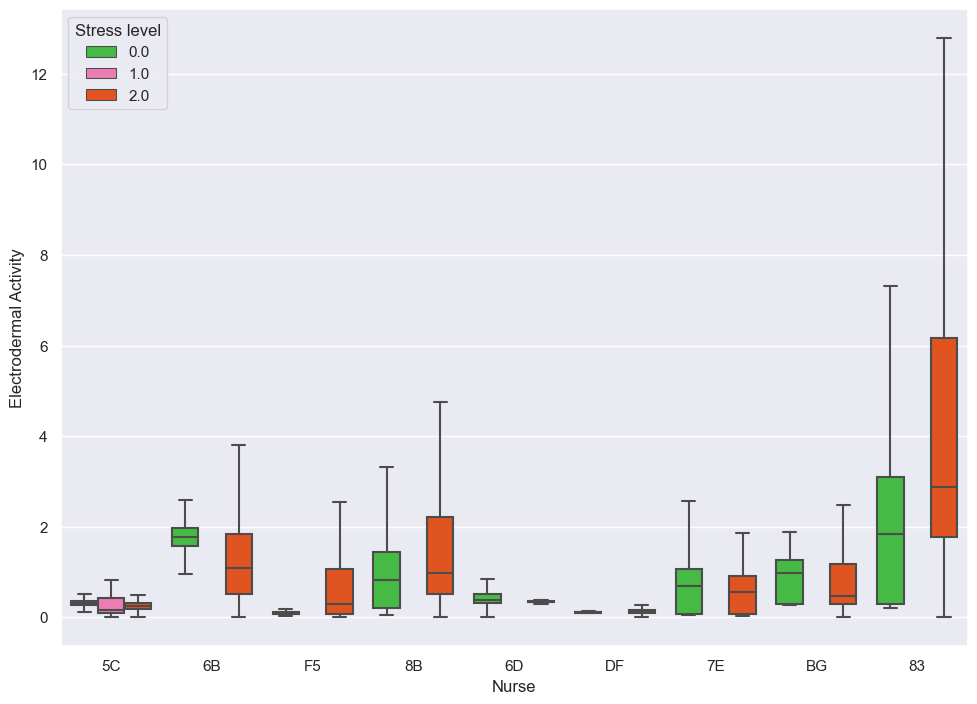

In [15]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='Nurse',y='Electrodermal Activity',hue='Stress level',data=box_plot_df.loc[(box_plot_df.Nurse!="E4")&
                                                                                         (box_plot_df.Nurse!="7A")&
                                                                                         (box_plot_df.Nurse!="94")],palette=my_pal,showfliers = False)

## Data Science Modelling
*   **Selecting the Best Combination of Features**
*   **Identifying the Best Model**
*   **Tuning the Parameters**
*   **Formulating the Results**

In [16]:
modelling_data = data.copy()
modelling_data = modelling_data.reset_index(drop=True)
modelling_data = modelling_data.rename(columns={"Blood Volume Pulse":"BVP","Temperature":"Temp","Electrodermal Activity":"EDA"})

**Condensing the Data in the form of a Summary Table for Analysis**

In [17]:
# Calculating Summary Statistics from the Sensor data

for col in ["ACC","BVP","EDA","Temp"]:
    temp = modelling_data.groupby(by=["Nurse","Start datetime","End datetime"])[col].apply(calculate_statistics)
    temp = temp.reset_index()
    temp[[col+'_median',col+'_mean',col+'_std',col+'_kurt',col+'_skew',
          col+'_mean_cross',col+'_entropy']] = pd.DataFrame(temp[col].tolist(),index= temp.index)
    temp = temp.drop(col,axis=1)
    modelling_data = modelling_data.merge(temp,how="left",on=["Nurse","Start datetime","End datetime"])

In [18]:
# Creating a DataFrame containing one Row for each Survey Record. The Table is also merged with the Summary Statistic table

modelling_data = modelling_data.drop(["Datetime","ACC_X","ACC_Y","ACC_Z","ACC","BVP","EDA",
                                      "Temp","Date"],axis=1)
modelling_data = modelling_data.drop_duplicates(subset=["Nurse","Start datetime","End datetime"])
modelling_data = modelling_data.drop(["Nurse","Start datetime","End datetime"],axis=1)
modelling_data = modelling_data.reset_index(drop=True)

**Problem Framing**

In [19]:
# Stress Level 1 is removed to keep things simpler
# Framing the Problem as Binary Classification Problem

modelling_data.loc[modelling_data["Stress level"] == 2.0,"Stress level"] = 1.0

# Checking for Null Values

isnull = pd.DataFrame(modelling_data.isnull().sum())
isnull.columns=["Missing_Values"]
isnull.T.style.background_gradient(cmap="Blues",high=0.5,low=0.5,axis=1)

,Stress level,COVID related,Treating a covid patient,Patient in Crisis,Patient or patient's family,Doctors or colleagues,Increased Workload,Technology related stress,Lack of supplies,Documentation,Competency related stress,Saftey (physical or physiological threats),Work Environment - Physical or others: work processes or procedures,ACC_median,ACC_mean,ACC_std,ACC_kurt,ACC_skew,ACC_mean_cross,ACC_entropy,BVP_median,BVP_mean,BVP_std,BVP_kurt,BVP_skew,BVP_mean_cross,BVP_entropy,EDA_median,EDA_mean,EDA_std,EDA_kurt,EDA_skew,EDA_mean_cross,EDA_entropy,Temp_median,Temp_mean,Temp_std,Temp_kurt,Temp_skew,Temp_mean_cross,Temp_entropy
Missing_Values,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Data Resampling**

In [20]:
# Checking No of Examples Per Class

class_counts = pd.DataFrame(modelling_data["Stress level"].value_counts())
class_counts.index = class_counts.index.astype('int64')
class_counts = class_counts.rename(columns={"Stress level":"Row Count"})
class_counts.index.name = "Stress level"
class_counts.T.style.background_gradient(cmap="Blues",high=0.25,low=0.25,axis=1)

Stress level,1,0
Row Count,136,31


In [21]:
# Balancing the Classes by Resampling

modelling_data_resampled = re_sample(modelling_data)

class_counts = pd.DataFrame(modelling_data_resampled["Stress level"].value_counts())
class_counts.index = class_counts.index.astype('int64')
class_counts = class_counts.rename(columns={"Stress level":"Row Count"})
class_counts.index.name = "Stress level"
class_counts.T.style.background_gradient(cmap="Blues",high=0.25,low=0.25,axis=1)

Stress level,0,1
Row Count,50,50


In [22]:
modelling_data_resampled.head()

,Stress level,COVID related,Treating a covid patient,Patient in Crisis,Patient or patient's family,Doctors or colleagues,Increased Workload,Technology related stress,Lack of supplies,Documentation,...,EDA_skew,EDA_mean_cross,EDA_entropy,Temp_median,Temp_mean,Temp_std,Temp_kurt,Temp_skew,Temp_mean_cross,Temp_entropy
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.220764,68,8.185294,34.00,34.046955,0.911346,-0.147822,-0.621140,45,4.586885
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.774362,238,4.341874,34.11,34.075926,0.099864,2.184646,-1.654221,33,2.619214
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.171351,124,7.545315,34.29,34.349908,0.263397,-0.251086,0.698522,33,3.798795
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.086455,10,5.920508,34.21,34.332744,0.332265,-0.732615,0.725269,3,3.276018
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.073699,15,7.214652,34.33,34.392791,0.244527,-1.694618,0.128281,1,3.202141


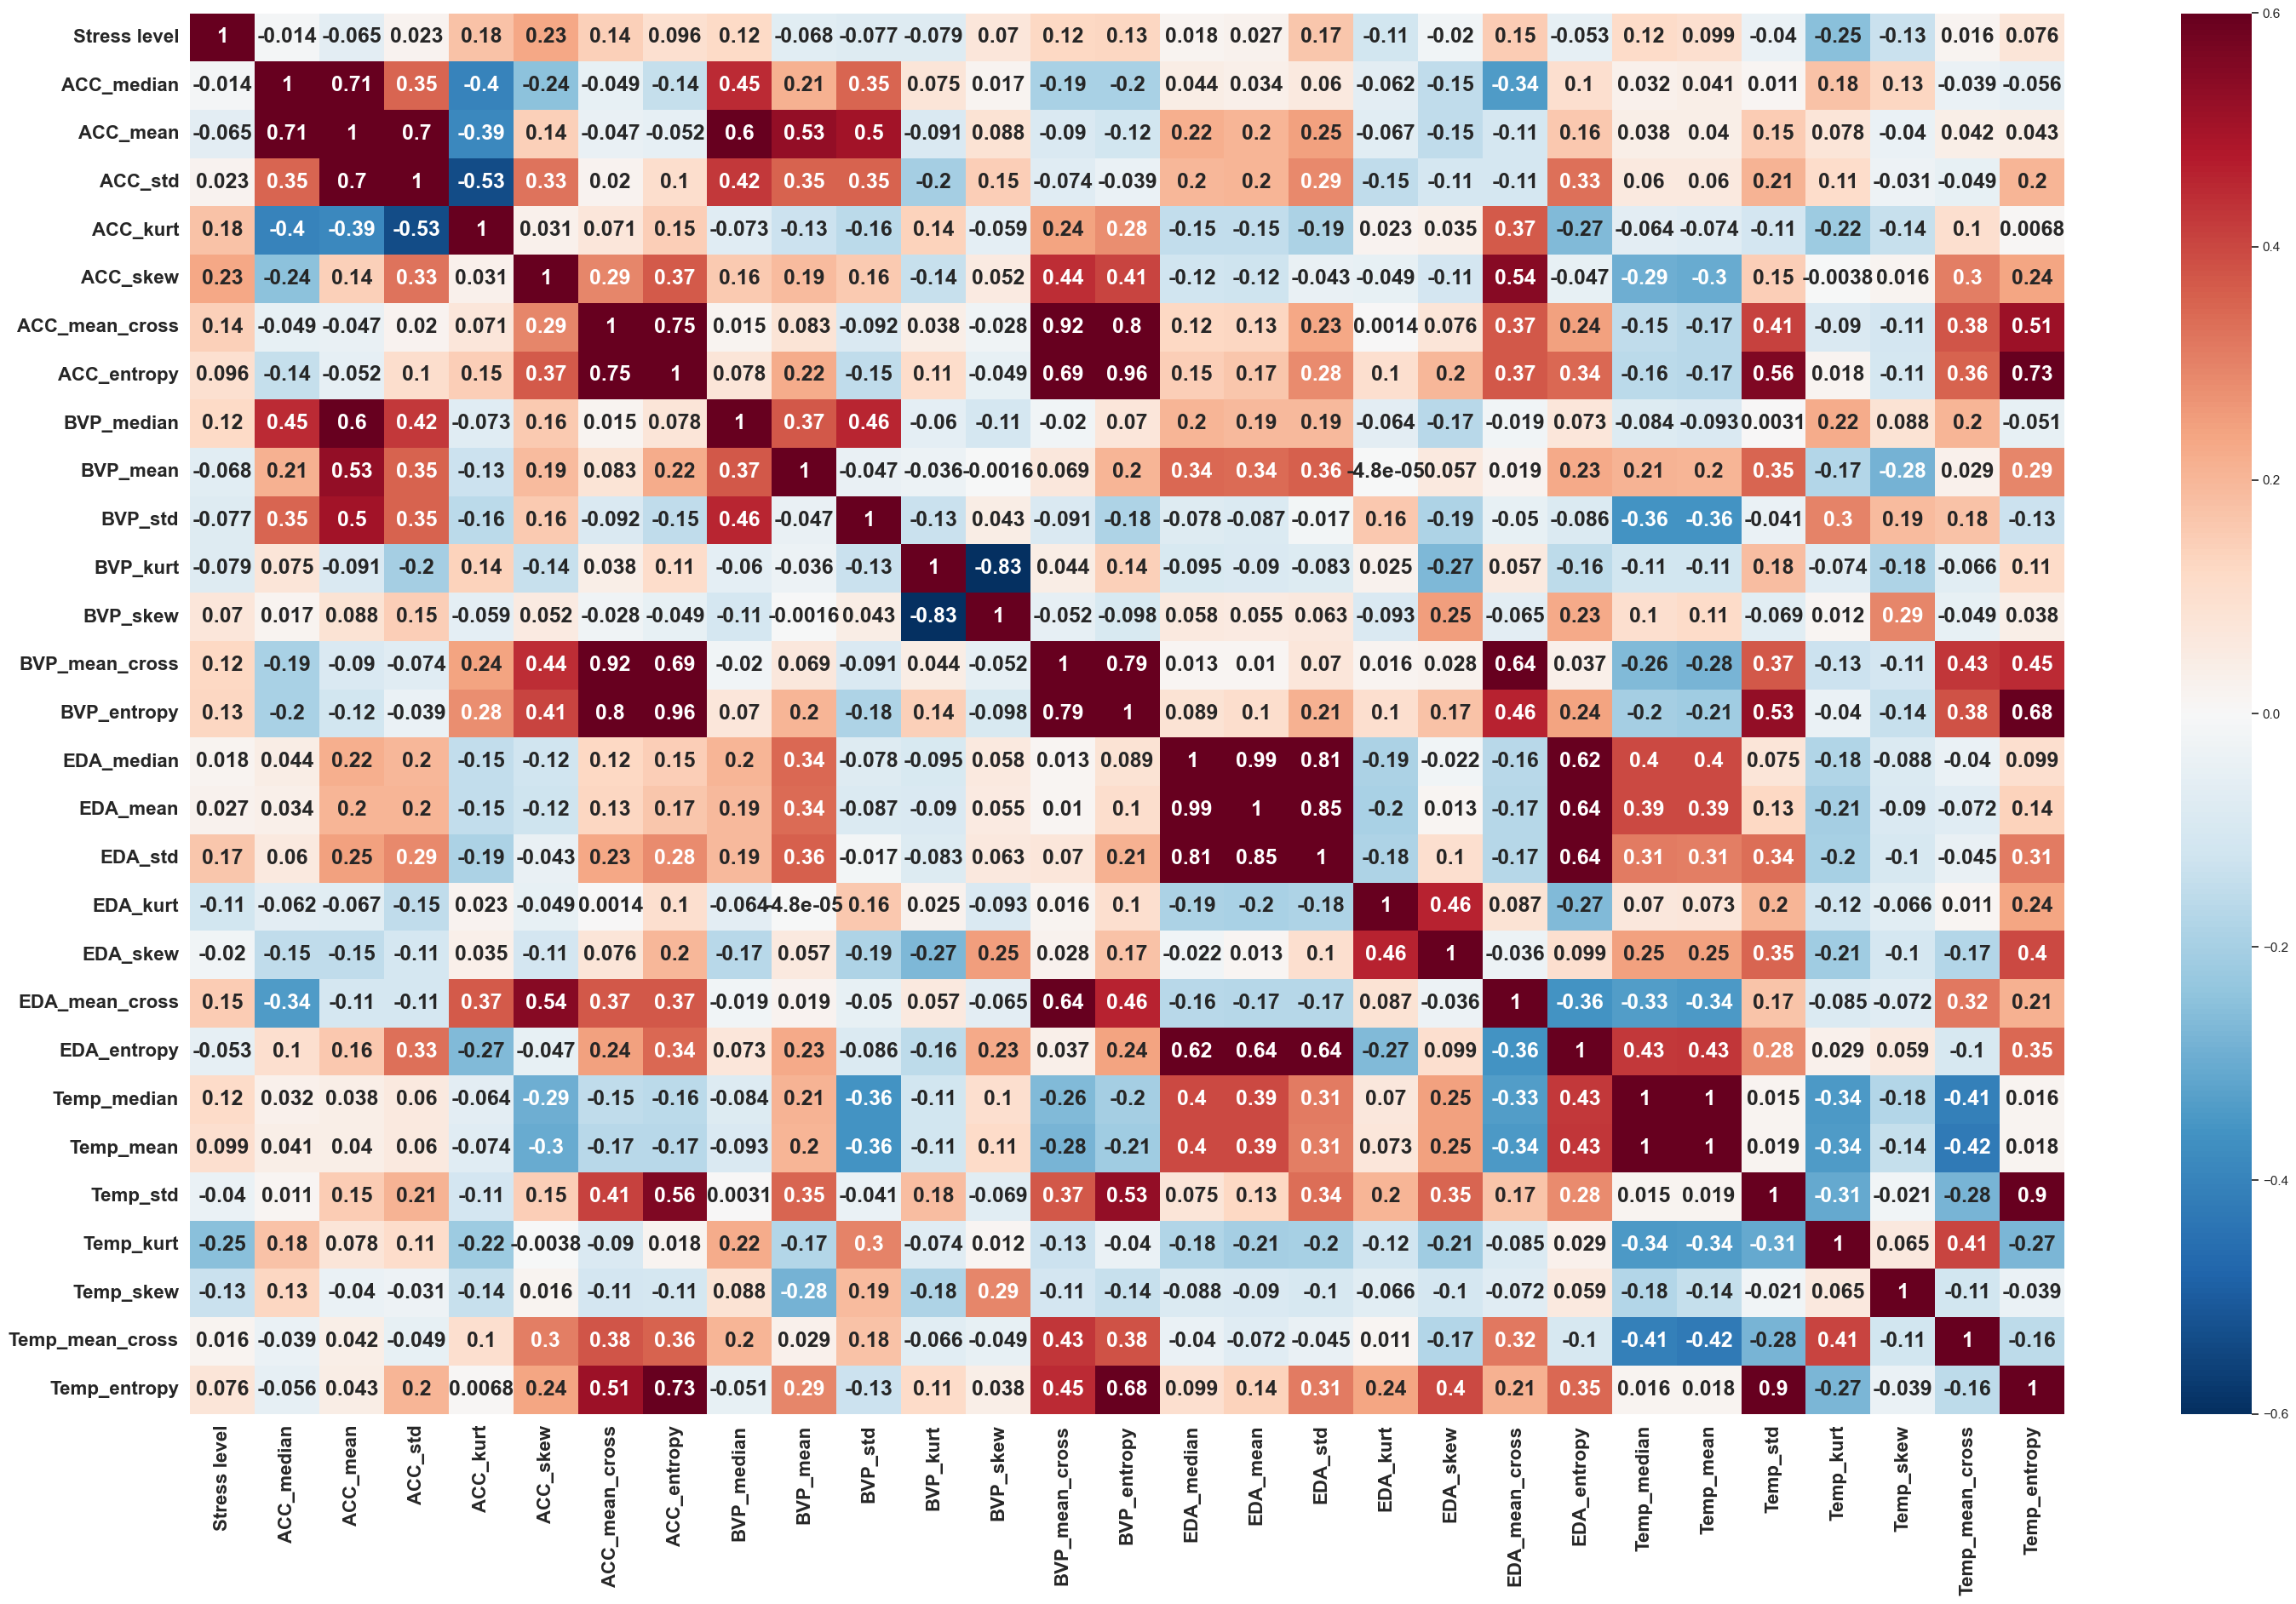

In [23]:
# Correlation Matrix
# Some Features that have high correlation with other features may be removed later on in Feature Selection as reducing MultiCollinearity results in
# better results

correlation = modelling_data_resampled[["Stress level"]+list(modelling_data_resampled.columns[13:])].rename(columns={"Work Environment - Physical or others: work processes or procedures":"Work Environment",
                                                       "Saftey (physical or physiological threats)":"Saftey"}).corr()
plt.figure(figsize=(30,19))
heatmap = sns.heatmap(correlation,annot=True,linewidths=0,vmin=-0.60,vmax=0.60,cmap="RdBu_r",annot_kws={"size":18,"weight":"bold"})
for label_x,label_y in zip(heatmap.get_xticklabels(),heatmap.get_yticklabels()):
    label_x.set_weight("bold")
    label_x.set_size(16)
    label_y.set_weight("bold")
    label_y.set_size(16)
plt.tight_layout()

**Test-Train Split**

In [24]:
# Implementing the 80-20 Train-Test Split

X = modelling_data_resampled.drop("Stress level",axis=1)
Y = modelling_data_resampled[["Stress level"]]
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,stratify=Y,test_size=0.20,random_state=0)

models = []
initial_scores = []
rfe_scores = []
final_scores = []

print("X_Train Shape is = ",X_train.shape)
print("X_Test Shape is = ",X_test.shape)
print("Y_Train Shape is = ",Y_train.shape)
print("Y_Test Shape is = ",Y_test.shape)

X_Train Shape is =  (80, 40)
X_Test Shape is =  (20, 40)
Y_Train Shape is =  (80, 1)
Y_Test Shape is =  (20, 1)


**Logistic Regression**

It is a widely used and interpretable method for Binary Classification problems which models the probability of a binary outcome and make predictions based on that probability

In [25]:
# Initializing the Model

lr = LogisticRegression(random_state=0,max_iter=100)
models.append("Logistic Regression")

In [26]:
# Min Max Scaling

scaler = MinMaxScaler(feature_range=(0,1))

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

In [27]:
# Initial Score

initial_score = np.mean(cross_val_score(lr,X_train_scaled,Y_train.values.ravel(),cv=10,scoring="f1",n_jobs=-1))
print("The Initial Cross-Validation Score is = ",round(initial_score,3))

# Test Score

lr.fit(X_train_scaled,Y_train.values.ravel())
Y_pred = lr.predict(X_test_scaled)
print("The Initial Test Score is = ",round(f1_score(Y_pred,Y_test),3))
initial_scores.append(round(f1_score(Y_pred,Y_test),3))

The Initial Cross-Validation Score is =  0.534
The Initial Test Score is =  0.636


In [28]:
# Feature Selection Using Recursive Feature Elimination

rfe = RFECV(estimator=lr,step=1,cv=10)
rfe.fit(X_train_scaled,Y_train.values.ravel())
print("Optimal number of features: %d" % rfe.n_features_)
print("The Cross-Validation Score after Feature Selection is = ",round(np.mean(rfe.cv_results_['mean_test_score']),3))

best_feats = [rfe.feature_names_in_[idx] for idx,x in enumerate(rfe.ranking_) if x ==1]
X_train_scaled_best = X_train_scaled[best_feats]
X_test_scaled_best = X_test_scaled[best_feats]

# Test Score

lr.fit(X_train_scaled_best,Y_train.values.ravel())
Y_pred = lr.predict(X_test_scaled_best)
print("The Test Score after Feature Selection is = ",round(f1_score(Y_pred,Y_test),3))
rfe_scores.append(round(f1_score(Y_pred,Y_test),3))

Optimal number of features: 30
The Cross-Validation Score after Feature Selection is =  0.555
The Test Score after Feature Selection is =  0.636


In [29]:
# Hyper Parameter Optimization

C = np.arange(0.05,2.5,0.05).tolist()
max_iter = [100,500,1000]
solver = ['lbfgs','liblinear','sag','saga','newton-cg']
tol = [0.001,0.0001]

hyperparameters = dict(C=C,solver=solver,max_iter=max_iter,tol=tol)
grid = GridSearchCV(lr,hyperparameters,cv=10,scoring="f1",n_jobs=-1)
best_model = grid.fit(X_train_scaled_best,Y_train.values.ravel())

print("The Best F1 Score after HyperParameter Optimization is = ",round(best_model.best_score_,2))
print("\nThe Chosen Parameters are =",best_model.best_estimator_.get_params())

# Test Score

lr = LogisticRegression(**best_model.best_estimator_.get_params())
lr.fit(X_train_scaled_best,Y_train.values.ravel())
Y_pred = lr.predict(X_test_scaled_best)
print("\nThe Test Score after Optimizing the Parameters is = ",round(f1_score(Y_pred,Y_test),3))
final_scores.append(round(f1_score(Y_pred,Y_test),3))

The Best F1 Score after HyperParameter Optimization is =  0.64

The Chosen Parameters are = {'C': 0.05, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.001, 'verbose': 0, 'warm_start': False}

The Test Score after Optimizing the Parameters is =  0.8


**Decision Tree Classifier**

It is a popular classification algorithm which works by recursively splitting the data based on the most important features until a stopping criterion is met, and then assigning a class label to each leaf node.

In [30]:
dt_clf = DecisionTreeClassifier(random_state=0)
models.append("Decision Tree Classifier")

In [31]:
# Initial Score

initial_score = np.mean(cross_val_score(dt_clf,X_train,Y_train.values.ravel(),cv=10,scoring="f1",n_jobs=-1))
print("The Initial Cross-Validation Score is = ",round(initial_score,3))

# Test Score

dt_clf.fit(X_train,Y_train.values.ravel())
Y_pred = dt_clf.predict(X_test)
print("The Initial Test Score is = ",round(f1_score(Y_pred,Y_test),3))
initial_scores.append(round(f1_score(Y_pred,Y_test),3))

The Initial Cross-Validation Score is =  0.691
The Initial Test Score is =  0.762


In [32]:
# Feature Selection Using Recursive Feature Elimination

rfe = RFECV(estimator=dt_clf,step=1,cv=10)
rfe.fit(X_train,Y_train.values.ravel())
print("Optimal number of features: %d" % rfe.n_features_)
print("The Cross-Validation Score after Feature Selection is = ",round(np.mean(rfe.cv_results_['mean_test_score']),3))

best_feats = [rfe.feature_names_in_[idx] for idx,x in enumerate(rfe.ranking_) if x ==1]
X_train_best = X_train[best_feats]
X_test_best = X_test[best_feats]

# Test Score

dt_clf.fit(X_train_best,Y_train.values.ravel())
Y_pred = dt_clf.predict(X_test_best)
print("The Test Score after Feature Selection is = ",round(f1_score(Y_pred,Y_test),3))
rfe_scores.append(round(f1_score(Y_pred,Y_test),3))

Optimal number of features: 11
The Cross-Validation Score after Feature Selection is =  0.734
The Test Score after Feature Selection is =  0.8


In [33]:
# Hyper Parameter Optimization

max_depth = range(1,21,1)
criterion = ["gini","entropy"]
max_features = ["auto","sqrt","log2",None]
min_samples_split = range(2,6,1)
min_samples_leaf = range(1,6,1)

hyperparameters = dict(criterion=criterion,max_features=max_features,max_depth=max_depth,
                       min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
grid = GridSearchCV(dt_clf,hyperparameters,cv=10,scoring="f1",n_jobs=-1)
best_model = grid.fit(X_train_best,Y_train.values.ravel())

print("The Best F1 Score after HyperParameter Optimization is = ",round(best_model.best_score_,2))
print("\nThe Chosen Parameters are =",best_model.best_estimator_.get_params())

# Test Score

dt_clf = DecisionTreeClassifier(**best_model.best_estimator_.get_params())
dt_clf.fit(X_train_best,Y_train.values.ravel())
Y_pred = dt_clf.predict(X_test_best)
print("\nThe Test Score after Optimizing the Parameters is = ",round(f1_score(Y_pred,Y_test),3))
final_scores.append(round(f1_score(Y_pred,Y_test),3))

The Best F1 Score after HyperParameter Optimization is =  0.81

The Chosen Parameters are = {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}

The Test Score after Optimizing the Parameters is =  0.8


**Light Gradient Boosting Classifier** 

It is a fast and efficient gradient boosting framework that uses histogram-based algorithms to split features, reducing memory usage and speeding up training. It can achieve high accuracy with relatively few hyperparameters.

In [34]:
model_lgb = lgb.LGBMClassifier(boosting_type="gbdt",random_state=0)
models.append("LGBM Classifier")

In [35]:
# Initial Score

initial_score = np.mean(cross_val_score(model_lgb,X_train.values,Y_train.values.ravel(),cv=10,scoring="f1",n_jobs=-1))
print("The Initial Cross-Validation Score is = ",round(initial_score,3))

# Test Score

model_lgb.fit(X_train.values,Y_train.values.ravel())
Y_pred = model_lgb.predict(X_test)
print("The Initial Test Score is = ",round(f1_score(Y_pred,Y_test),3))
initial_scores.append(round(f1_score(Y_pred,Y_test),3))

The Initial Cross-Validation Score is =  0.719
The Initial Test Score is =  0.8


In [36]:
# Feature Selection Using Recursive Feature Elimination

rfe = RFECV(estimator=model_lgb,step=1,cv=10)
rfe.fit(X_train,Y_train.values.ravel())
print("Optimal number of features: %d" % rfe.n_features_)
print("The Cross-Validation Score after Feature Selection is = ",round(np.mean(rfe.cv_results_['mean_test_score']),3))

best_feats = [rfe.feature_names_in_[idx] for idx,x in enumerate(rfe.ranking_) if x ==1]
X_train_best = X_train[best_feats]
X_test_best = X_test[best_feats]

# Test Score

model_lgb.fit(X_train_best.values,Y_train.values.ravel())
Y_pred = model_lgb.predict(X_test_best)
print("The Test Score after Feature Selection is = ",round(f1_score(Y_pred,Y_test),3))
rfe_scores.append(round(f1_score(Y_pred,Y_test),3))

Optimal number of features: 10
The Cross-Validation Score after Feature Selection is =  0.747
The Test Score after Feature Selection is =  0.857


In [37]:
# Hyper Parameter Optimization

n_estimators = [100,250,500,750,1000]
num_leaves = [21,31,41]
learning_rate = [0.001,0.01,0.1]

hyperparameters = dict(n_estimators=n_estimators,num_leaves=num_leaves,
                       learning_rate=learning_rate)
grid = GridSearchCV(model_lgb,hyperparameters,cv=10,scoring="f1",n_jobs=-1)
best_model = grid.fit(X_train_best.values,Y_train.values.ravel())

print("The Best F1 Score after HyperParameter Optimization is = ",round(best_model.best_score_,2))
print("\nThe Chosen Parameters are =",best_model.best_estimator_.get_params())

# Test Score

model_lgb = lgb.LGBMClassifier(**best_model.best_estimator_.get_params())
model_lgb.fit(X_train_best.values,Y_train.values.ravel())
Y_pred = model_lgb.predict(X_test_best)
print("\nThe Test Score after Optimizing the Parameters is = ",round(f1_score(Y_pred,Y_test),3))
final_scores.append(round(f1_score(Y_pred,Y_test),3))

The Best F1 Score after HyperParameter Optimization is =  0.79

The Chosen Parameters are = {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 21, 'objective': None, 'random_state': 0, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}

The Test Score after Optimizing the Parameters is =  0.857


**Selecting Best Model**

In [38]:
# Results Table

results = pd.DataFrame(data={"Initial Scores":initial_scores,"RFE Scores":rfe_scores,"Param_Opt Scores":final_scores},index=models)
print("The Best Model is =",results.loc[results["Param_Opt Scores"]==results["Param_Opt Scores"].max()].index[0])
results.style.background_gradient(cmap="Blues",high=0.857,low=0.636,axis=None)

The Best Model is = LGBM Classifier


,Initial Scores,RFE Scores,Param_Opt Scores
Logistic Regression,0.636000,0.636000,0.800000
Decision Tree Classifier,0.762000,0.800000,0.800000
LGBM Classifier,0.800000,0.857000,0.857000


**Visualizing the Results and Features of the Best Model**

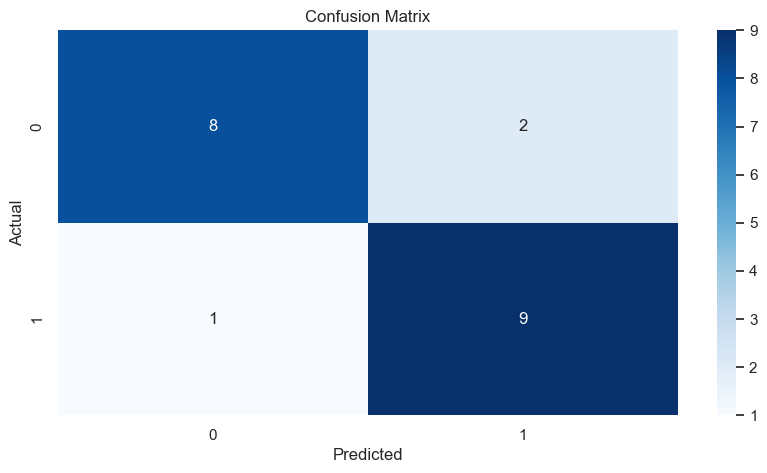

In [39]:
# Plotting the Confusion Matrix

plot_confusion_matrix(Y_test,Y_pred,[0,1])

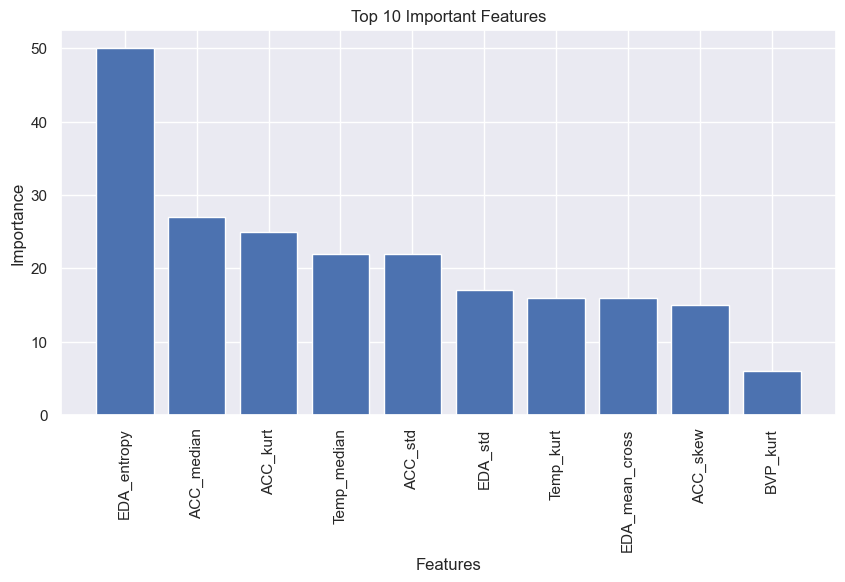

In [40]:
# Plotting the top 5 Features and their Importances

model_lgb.fit(X_train_best.values,Y_train.values.ravel())
importances = model_lgb.feature_importances_
indices = importances.argsort()[::-1] 
plt.figure(figsize=(10,5))
plt.bar(range(len(indices[:10])),importances[indices[:10]])
plt.xticks(range(len(indices[:10])),X_train_best.columns[indices[:10]], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Top 10 Important Features")
plt.show()

## Conclusion

We observed that some of the sensor data seemed less important such as Blood Volume Pulse as its variation didnt have much effect on the Stress Levels. Other signals such as Temperature, Electrodermal Activity and Temperature seemed significant for the task of detecting stress